# CSCA 5632 Mini Project: BBC News Classification

In [579]:
import os
import json
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from helpers.metrics import *

# for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
# nltk.download('stopwords')
# nltk.download('punkt_tab')
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF


In [580]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# please, no warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ['PYTHONWARNINGS']='ignore'

## Exploratory Data Analysis (EDA)

In [581]:
df_train = pd.read_csv('./data/news/BBC News Train.csv')
df_test = pd.read_csv('./data/news/BBC News Test.csv')

### Data inspection

In [582]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [583]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


Train dataset has 1490 data points with article ID, article text and category labels. Test dataset has 735 entries with article ID and article text, but no labels. Both train and test data have only non-null values, so we do not need to drop any entries based on null values.

### Drop Duplicates

Although we did not have to drop any null values, we should still check for duplicates in train data.

In [584]:
df_train = df_train.drop_duplicates(subset=['Text'])
df_train

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


After dropping duplicates, we are left with 1440 entries (50 dropped).

### Check Class Imbalance

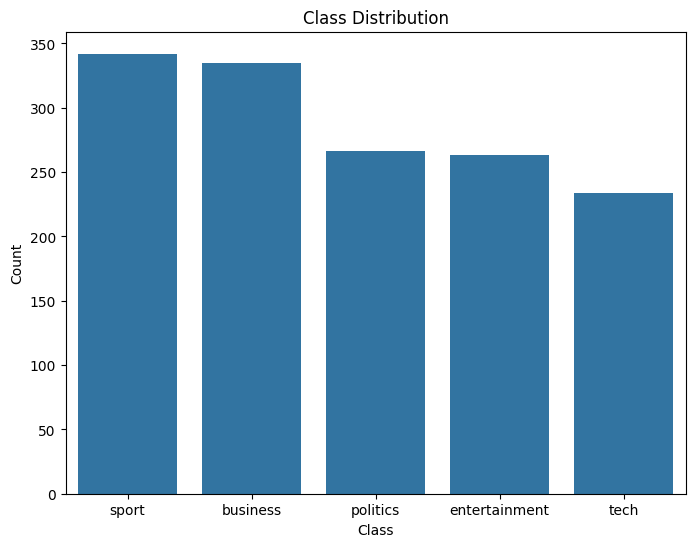

In [585]:
class_counts = df_train['Category'].value_counts()

# bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

There is a slight imbalance in labels towards sports and business articles, but it seems each label has decent representation.

### Text Cleaning

Next, we must perform preprocessing specific to the texts. Below is an example of an unprocessed text.

#### Before cleaning:

In [586]:
df_train.iloc[0]['Text']

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

Some low hanging fruits in cleaning the texts involve ensuring that they are all in lower case and stripping away punctuations, but I found an exhaustive list of text cleaning in a related Kaggle Notebook [[1](#[1]-https://www.kaggle.com/code/jieshends2020/matrix-factorization-97-acc-with-1-labels/notebook)], some of which we will consider:

1. Ensure letters are all lower case
2. Remove punctuation
3. Remove extra whitespaces
4. Remove stop words
5. Reduce words to stems

We want to remove stop words such as the definite and indefinite articles "the" and "a/an", because even though they are some of the most frequent words in a body of text, they do not provide much context clues. Furthermore, we want to reduce words to its stems because we could get stronger signals for topics if variations of the same words were reduced to a common form.

In [587]:
# ensure lower case
df_train['Text'] = df_train['Text'].str.lower()
df_test['Text'] = df_test['Text'].str.lower()

# remove punctuation
df_train['Text'] = df_train['Text'].apply(lambda doc: re.sub(r'[^\w\s]+', '', doc))
df_test['Text'] = df_test['Text'].apply(lambda doc: re.sub(r'[^\w\s]+', '', doc))

# remove stop words
stop_words = nltk.corpus.stopwords.words('english')
df_train['Text'] = df_train['Text'].apply(lambda doc: ' '.join([word for word in doc.split() if word not in (stop_words)]))
df_test['Text'] = df_test['Text'].apply(lambda doc: ' '.join([word for word in doc.split() if word not in (stop_words)]))

# remove extra white spaces
df_train['Text'] = df_train['Text'].apply(lambda doc: re.sub(' +', ' ', doc))
df_test['Text'] = df_test['Text'].apply(lambda doc: re.sub(' +', ' ', doc))

# stemming
porter_stemmer = PorterStemmer()
df_train['Text'] = df_train['Text'].apply(lambda doc:  [porter_stemmer.stem(word) for word in word_tokenize(doc) ])
df_train['Text'] = df_train['Text'].apply(lambda words: ' '.join(words))
df_test['Text'] = df_test['Text'].apply(lambda doc:  [porter_stemmer.stem(word) for word in word_tokenize(doc) ])
df_test['Text'] = df_test['Text'].apply(lambda words: ' '.join(words))


In [588]:
df_train['Text']

0       worldcom exboss launch defenc lawyer defend fo...
1       german busi confid slide german busi confid fe...
2       bbc poll indic econom gloom citizen major nati...
3       lifestyl govern mobil choic faster better funk...
4       enron boss 168m payout eighteen former enron d...
                              ...                        
1485    doubl evict big brother model capric holbi cit...
1486    dj doubl act revamp chart show dj duo jk joel ...
1487    weak dollar hit reuter revenu media group reut...
1488    appl ipod famili expand market appl expand ipo...
1489    santi worm make unwelcom visit thousand websit...
Name: Text, Length: 1440, dtype: object

In [589]:
df_test['Text']

0      qpr keeper day head preston queen park ranger ...
1      softwar watch work softwar monitor everi keyst...
2      arci injuri add ireland woe gordon arci rule i...
3      india relianc famili feud heat ongo public spa...
4      boro suffer morrison injuri blow middlesbrough...
                             ...                        
730    eu probe alitalia state aid european commiss o...
731    u2 play grammi award show irish rock band u2 p...
732    sport bet rule spotlight group mp peer call ti...
733    alfa romeo get gm engin fiat stop make sixcyli...
734    citizenship event 18 tout citizenship ceremoni...
Name: Text, Length: 735, dtype: object

#### After Cleaning:

In [590]:
df_train.iloc[0]['Text']

'worldcom exboss launch defenc lawyer defend former worldcom chief berni ebber batteri fraud charg call compani whistleblow first wit cynthia cooper worldcom exhead intern account alert director irregular account practic us telecom giant 2002 warn led collaps firm follow discoveri 11bn 57bn account fraud mr ebber plead guilti charg fraud conspiraci prosecut lawyer argu mr ebber orchestr seri account trick worldcom order employe hide expens inflat revenu meet wall street earn estim ms cooper run consult busi told juri new york wednesday extern auditor arthur andersen approv worldcom account earli 2001 2002 said andersen given green light procedur practic use worldcom mr ebber lawyer said unawar fraud argu auditor alert problem ms cooper also said sharehold meet mr ebber often pass technic question compani financ chief give brief answer prosecut star wit former worldcom financi chief scott sullivan said mr ebber order account adjust firm tell hit book howev ms cooper said mr sullivan men

## Model Training

##### Q: When training an unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?

Test data should not be included in the model training as it will introduce data leak. By not including test data, model trained on the train dataset will be able to generalize better.


### NMF prototype

In [591]:
unique_labels = sorted(list(df_train['Category'].unique()))
print(unique_labels)

# helper function from CSCA 5632 Week 2 Lab
def label_permute_compare(ytdf,yp,n=5):
    permutations = list(itertools.permutations(range(n)))
    
#     print(yp)
#     print(np.take((0,1,2,3,'hello world'), yp))
    
    max_acc = float('-inf')
    permutation_ = None
    prediction_ = None
    
    for permutation in permutations:
        cluster_to_index = np.take(permutation, yp)
        prediction = np.take(unique_labels, cluster_to_index)
        # prediction = [unique_labels[permutation[i]] for i in yp]
        
        acc = sum(ytdf.Category == prediction)/ytdf.Category.shape[0]
        if acc > max_acc:
            max_acc = acc
            permutation_ = permutation
            prediction_ = prediction

    return permutation_, max_acc

['business', 'entertainment', 'politics', 'sport', 'tech']


In [592]:
# Vectorizer + NMF wrapper
def nmf_wrapper(train, **kwargs):
    tfidf = TfidfVectorizer(**kwargs)
    tfidf_train = tfidf.fit_transform(train['Text'])
    
    nmf = NMF(n_components=5,
              init='nndsvda', 
              solver = 'mu',
              beta_loss = 'kullback-leibler',
              random_state = 0)
    nmf_train = nmf.fit_transform(tfidf_train)
    yp = np.argmax(nmf_train, axis=1)
    
    label_order, accuracy = label_permute_compare(train, yp)

    # return the model, order of labels and accuracy
    return tfidf, nmf, label_order, accuracy

In [593]:
# try a set of parameters
args = {
    'min_df': 5,
    'max_df': .8,
    'max_features': 500
}

best_vectorizer, best_model, best_label_order, accuracy = nmf_wrapper(df_train, **args)
print(best_model, best_label_order, accuracy)

NMF(beta_loss='kullback-leibler', init='nndsvda', n_components=5,
    random_state=0, solver='mu') (0, 3, 1, 2, 4) 0.9340277777777778


In [594]:
tfidf_test = best_vectorizer.transform(df_test['Text'])
nmf_test = best_model.transform(tfidf_test)
yp = np.argmax(nmf_test, axis=1)
# prediction = [unique_labels[best_label_order[i]] for i in yp]
cluster_to_index = np.take(best_label_order, yp)
prediction = np.take(unique_labels, cluster_to_index)

result = pd.DataFrame()
result['ArticleId'] = df_test.ArticleId
result['Category'] = prediction

result.to_csv('./results/submission_no_tuning.csv', index=False)
result

# 92.653% test accuracy on Kaggle

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,politics
733,206,business


In [595]:
tfidf_train = best_vectorizer.transform(df_train['Text'])
nmf_train = best_model.transform(tfidf_train)
yp = np.argmax(nmf_train, axis=1)
cluster_to_index = np.take(permutation, yp)
prediction = np.take(unique_labels, cluster_to_index)

test_labels = np.array(df_train['Category'])

print(f"Prediction: {prediction} \n")
print(f"True Label: {test_labels} \n")

# Calculate Accuracy
total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
accuracy = correct/total

# Construct confusion matrix
confusion_mat = confusion_matrix(test_labels, prediction)

# Calculate Precision
_precision = precision(confusion_mat)
# Calculate Recall
_recall = recall(confusion_mat)

print(confusion_mat)
print(f"accuracy: {accuracy}")
print(f"precision: {_precision}")
print(f"recall: {_recall}")


Prediction: ['business' 'business' 'business' ... 'business' 'tech' 'tech'] 

True Label: ['business' 'business' 'business' ... 'business' 'tech' 'tech'] 

[[303   2  24   0   6]
 [  6 239   9   2   7]
 [  4   0 255   3   4]
 [  3   2   0 337   0]
 [  4   7   6   5 212]]
accuracy: 0.9347222222222222
precision: 0.9334335374222427
recall: 0.9326464997143823


### NMF hyperparameter tuning

Although we have a separate test dataset from the competition, we should split the train dataset for validation sets to achieve the most unbiased result. First we will modify the NMF wrapper to take input and label as separate series.

In [596]:
def label_permute_compare(ytdf,yp,n=5):
    permutations = list(itertools.permutations(range(n)))
    
    max_acc = float('-inf')
    permutation_ = None
    prediction_ = None
    
    for permutation in permutations:
        cluster_to_index = np.take(permutation, yp)
        prediction = np.take(unique_labels, cluster_to_index)
        # prediction = [unique_labels[permutation[i]] for i in yp]
        
        acc = sum(ytdf == prediction)/ytdf.shape[0]
        if acc > max_acc:
            max_acc = acc
            permutation_ = permutation
            prediction_ = prediction

    return permutation_, max_acc

In [597]:
# Vectorizer + NMF wrapper
def nmf_wrapper(x_train, y_train, **kwargs):
    tfidf = TfidfVectorizer(**kwargs)
    tfidf_train = tfidf.fit_transform(x_train)
    
    nmf = NMF(n_components=5,
              init='nndsvda', 
              solver = 'mu',
              beta_loss = 'kullback-leibler',
              random_state = 0)
    nmf_train = nmf.fit_transform(tfidf_train)
    yp = np.argmax(nmf_train, axis=1)
    
    label_order, accuracy = label_permute_compare(y_train, yp)

    # return the model, order of labels and accuracy
    return tfidf, nmf, label_order, accuracy

In [598]:
X_train, X_test, Y_train, Y_test =  train_test_split(df_train.Text, df_train.Category, test_size=0.1, random_state=42)

In [599]:
# tune parameters
summary_stats = {
    'model': [],
    'params': [],
    'train accuracy': [],
    'train precision': [],
    'train recall': [],
    'test accuracy': [],
    'test precision': [],
    'test recall': []
}

max_accuracy = float('-inf')
best_vectorizer = None
best_model = None
best_label_order = None
best_args = None

for min_df in [5, 7, 9]:
    for max_df in [.8, .9, .95]:
        for max_features in [500, 1000, 1500]:
            args = {
                'min_df': min_df,
                'max_df': max_df,
                'max_features': max_features
            }
            
            vectorizer, model, permutation, accuracy = nmf_wrapper(X_train, Y_train, **args)
            print(permutation, accuracy)

            ### TRAIN PERFORMANCE
            # Predict using Vectorizer, model and best label order
            tfidf_train = vectorizer.transform(X_train)
            nmf_train = model.transform(tfidf_train)
            yp = np.argmax(nmf_train, axis=1)
            cluster_to_index = np.take(permutation, yp)
            
            prediction = np.take(unique_labels, cluster_to_index)
            test_labels = np.array(Y_train)

            # Calculate Accuracy
            total = len(np.array(prediction == test_labels))
            correct = len(np.where(np.array(prediction == test_labels) == True)[0])
            accuracy = correct/total
            
            # Construct confusion matrix
            confusion_mat = confusion_matrix(test_labels, prediction)
            
            # Calculate Precision
            _precision = precision(confusion_mat)
            # Calculate Recall
            _recall = recall(confusion_mat)


            summary_stats['model'].append("NMF")
            summary_stats['params'].append(json.dumps(args))
            summary_stats['train accuracy'].append(accuracy)
            summary_stats['train precision'].append(_precision)
            summary_stats['train recall'].append(_recall)


            ### TEST PERFORMANCE
            # Predict using Vectorizer, model and best label order
            tfidf_test = vectorizer.transform(X_test)
            nmf_test = model.transform(tfidf_test)
            yp = np.argmax(nmf_test, axis=1)
            cluster_to_index = np.take(permutation, yp)
            
            prediction = np.take(unique_labels, cluster_to_index)
            test_labels = np.array(Y_test)

            # Calculate Accuracy
            total = len(np.array(prediction == test_labels))
            correct = len(np.where(np.array(prediction == test_labels) == True)[0])
            accuracy = correct/total
            
            # Construct confusion matrix
            confusion_mat = confusion_matrix(test_labels, prediction)
            
            # Calculate Precision
            _precision = precision(confusion_mat)
            # Calculate Recall
            _recall = recall(confusion_mat)

            summary_stats['test accuracy'].append(accuracy)
            summary_stats['test precision'].append(_precision)
            summary_stats['test recall'].append(_recall)

            # We will take the best model according to validation/test score
            if accuracy > max_accuracy:
                max_accuracy = accuracy
                best_vectorizer = vectorizer
                best_model = model
                best_label_order = permutation
                best_args = args

print(best_vectorizer, best_model, best_label_order, best_args)


(2, 3, 1, 0, 4) 0.9359567901234568
(0, 3, 1, 2, 4) 0.9567901234567902
(3, 0, 1, 2, 4) 0.9529320987654321
(2, 3, 1, 0, 4) 0.9359567901234568
(0, 3, 1, 2, 4) 0.9575617283950617
(0, 3, 1, 2, 4) 0.9567901234567902
(2, 3, 1, 0, 4) 0.9359567901234568
(0, 3, 1, 2, 4) 0.9575617283950617
(0, 3, 1, 2, 4) 0.9567901234567902
(2, 3, 1, 0, 4) 0.9367283950617284
(0, 3, 1, 2, 4) 0.9583333333333334
(3, 0, 1, 2, 4) 0.9513888888888888
(2, 3, 1, 0, 4) 0.9344135802469136
(0, 3, 1, 2, 4) 0.9575617283950617
(0, 3, 1, 2, 4) 0.9552469135802469
(2, 3, 1, 0, 4) 0.9344135802469136
(0, 3, 1, 2, 4) 0.9575617283950617
(0, 3, 1, 2, 4) 0.9552469135802469
(2, 3, 1, 0, 4) 0.9359567901234568
(0, 3, 1, 2, 4) 0.9552469135802469
(0, 3, 1, 2, 4) 0.9529320987654321
(2, 3, 1, 0, 4) 0.933641975308642
(0, 3, 1, 2, 4) 0.9591049382716049
(0, 3, 1, 2, 4) 0.9537037037037037
(2, 3, 1, 0, 4) 0.933641975308642
(0, 3, 1, 2, 4) 0.9591049382716049
(0, 3, 1, 2, 4) 0.9537037037037037
TfidfVectorizer(max_df=0.9, max_features=1500, min_df=5) 

In [600]:
df_summary_stats = pd.DataFrame(summary_stats)
df_summary_stats

,model,params,train accuracy,train precision,train recall,test accuracy,test precision,test recall
0,NMF,"{""min_df"": 5, ""max_df"": 0.8, ""max_features"": 500}",0.936728,0.935159,0.934419,0.881944,0.890286,0.892568
1,NMF,"{""min_df"": 5, ""max_df"": 0.8, ""max_features"": 1...",0.957562,0.955576,0.955467,0.902778,0.909826,0.905611
2,NMF,"{""min_df"": 5, ""max_df"": 0.8, ""max_features"": 1...",0.952932,0.951778,0.950800,0.909722,0.915212,0.913304
3,NMF,"{""min_df"": 5, ""max_df"": 0.9, ""max_features"": 500}",0.935957,0.934702,0.933474,0.881944,0.890286,0.892568
4,NMF,"{""min_df"": 5, ""max_df"": 0.9, ""max_features"": 1...",0.957562,0.955576,0.955467,0.909722,0.917058,0.909959
5,NMF,"{""min_df"": 5, ""max_df"": 0.9, ""max_features"": 1...",0.956019,0.954091,0.955229,0.916667,0.920676,0.920996
6,NMF,"{""min_df"": 5, ""max_df"": 0.95, ""max_features"": ...",0.935957,0.934702,0.933474,0.881944,0.890286,0.892568
7,NMF,"{""min_df"": 5, ""max_df"": 0.95, ""max_features"": ...",0.957562,0.955576,0.955467,0.909722,0.917058,0.909959
8,NMF,"{""min_df"": 5, ""max_df"": 0.95, ""max_features"": ...",0.956019,0.954091,0.955229,0.916667,0.920676,0.920996
9,NMF,"{""min_df"": 7, ""max_df"": 0.8, ""max_features"": 500}",0.935957,0.934200,0.933727,0.881944,0.890286,0.892568


In [601]:
tfidf_test = best_vectorizer.transform(df_test.Text)
nmf_test = best_model.transform(tfidf_test)
yp = np.argmax(nmf_test, axis=1)
# prediction = [unique_labels[best_label_order[i]] for i in yp]
cluster_to_index = np.take(best_label_order, yp)
prediction = np.take(unique_labels, cluster_to_index)

result = pd.DataFrame()
result['ArticleId'] = df_test.ArticleId
result['Category'] = prediction

result.to_csv('./results/submission.csv', index=False)
result

# 95.646% test accuracy on Kaggle

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,politics
733,206,business


In [602]:
tfidf_train = best_vectorizer.transform(X_test)
nmf_train = best_model.transform(tfidf_train)
yp = np.argmax(nmf_train, axis=1)
cluster_to_index = np.take(best_label_order, yp)

prediction = np.take(unique_labels, cluster_to_index)
train_labels = np.array(Y_test)

# Calculate Accuracy
total = len(np.array(prediction == train_labels))
correct = len(np.where(np.array(prediction == train_labels) == True)[0])
accuracy = correct/total

# Construct confusion matrix
confusion_mat = confusion_matrix(test_labels, prediction)

# Calculate Precision
_precision = precision(confusion_mat)
# Calculate Recall
_recall = recall(confusion_mat)

print(confusion_mat)
print(f"accuracy: {accuracy}")
print(f"precision: {_precision}")
print(f"recall: {_recall}")

[[41  0  2  0  3]
 [ 0 17  1  0  0]
 [ 3  0 23  0  0]
 [ 0  0  0 28  0]
 [ 0  0  2  1 23]]
accuracy: 0.9166666666666666
precision: 0.9206758758482895
recall: 0.9209959123002601


By tuning the vectorizer parameters we were able to improve the initial accuracy (Kaggle submission) of 92.653% to 95.646%!

### Supervised Learning

We will use support vector machine with linear kernel as our supervised learning model and compare its performance with matrix factorization. But first, we will tune for the supervised model for the best parameters

In [603]:
X_train, X_test, Y_train, Y_test =  train_test_split(df_train.Text, df_train.Category, test_size=0.1, random_state=42)

In [604]:
from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
from sklearn.svm import LinearSVC

parameters = {'loss': ['hinge', 'squared_hinge'],
              'C':np.logspace(-2, 0, 301, base=2)}
svc = LinearSVC(random_state=1)
grid = GridSearchCV(svc, parameters, cv=10, n_jobs=-1, scoring='accuracy')

tfidf_train = best_vectorizer.transform(X_train)
grid.fit(tfidf_train, Y_train)

best_params = grid.best_params_
best_score = grid.best_score_

print(f"best params: {best_params}")
print(f"cross validation score: {best_score}")

best params: {'C': np.float64(0.5116869459983875), 'loss': 'squared_hinge'}
cross validation score: 0.9745080500894454


In [605]:
prediction = grid.best_estimator_.predict(best_vectorizer.transform(X_test))
train_labels = np.array(Y_test)

# Calculate Accuracy
total = len(np.array(prediction == train_labels))
correct = len(np.where(np.array(prediction == train_labels) == True)[0])
accuracy = correct/total

# Construct confusion matrix
confusion_mat = confusion_matrix(test_labels, prediction)

# Calculate Precision
_precision = precision(confusion_mat)
# Calculate Recall
_recall = recall(confusion_mat)

print("Linear SVC Test Summary") 
print(confusion_mat)
print(f"accuracy: {accuracy}")
print(f"precision: {_precision}")
print(f"recall: {_recall}")

Linear SVC Test Summary
[[43  0  0  0  3]
 [ 0 18  0  0  0]
 [ 3  0 23  0  0]
 [ 0  0  0 28  0]
 [ 0  0  0  1 25]]
accuracy: 0.9513888888888888
precision: 0.9586313985864212
recall: 0.9561872909698996


In [606]:
prediction = grid.best_estimator_.predict(best_vectorizer.transform(df_test.Text))

result = pd.DataFrame()
result['ArticleId'] = df_test.ArticleId
result['Category'] = prediction

result.to_csv('./results/SVC.csv', index=False)
result

# 98.095% accuracy on Kaggle!

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,politics
733,206,business


Finally, we will trying using varying proportions of training data for NMF, then perform SVC with the same proportions.

In [607]:
comparison_stats = {
    'train proportion' : [],
    'SVC test accuracy': [],
    'NMF test accuracy': []
}

nmf_models = {}
svc_models = {}

for p in range(1, 10):
    comparison_stats['train proportion'].append(p * 0.1)
    
    X_train, X_test, Y_train, Y_test =  train_test_split(df_train.Text, df_train.Category, train_size=0.1 * p, random_state=42)
    print(len(X_train))
    train_tokenized = best_vectorizer.transform(X_train)
    test_tokenized = best_vectorizer.transform(X_test)

    # SVC
    parameters = {'loss': ['hinge', 'squared_hinge'],
              'C':np.logspace(-2, 0, 301, base=2)}
    svc = LinearSVC(random_state=1)
    # we will use 5 fold cross validation to save time
    grid = GridSearchCV(svc, parameters, cv=5, n_jobs=-1, scoring='accuracy')

    grid.fit(train_tokenized, Y_train)

    # save model in memory
    svc_models[p] = grid.best_estimator_

    prediction = grid.best_estimator_.predict(test_tokenized)
    test_labels = np.array(Y_test)
    
    # Calculate Accuracy
    total = len(np.array(prediction == test_labels))
    correct = len(np.where(np.array(prediction == test_labels) == True)[0])
    accuracy = correct/total
    comparison_stats['SVC test accuracy'].append(accuracy)

    # NMF
    nmf = NMF(n_components=5,
              init='nndsvda', 
              solver = 'mu',
              beta_loss = 'kullback-leibler',
              random_state = 0)
    nmf_train = nmf.fit_transform(train_tokenized)
    # save model in memory
    nmf_models[p] = nmf
    
    yp = np.argmax(nmf_train, axis=1)
    permutation, accuracy = label_permute_compare(Y_train, yp)

    nmf_test = nmf.transform(test_tokenized)
    yp = np.argmax(nmf_test, axis=1)
    
    cluster_to_index = np.take(permutation, yp)
    prediction = np.take(unique_labels, cluster_to_index)
    test_labels = np.array(Y_test)
    
    # Calculate Accuracy
    total = len(np.array(prediction == test_labels))
    correct = len(np.where(np.array(prediction == test_labels) == True)[0])
    accuracy = correct/total
    comparison_stats['NMF test accuracy'].append(accuracy)


144
288
432
576
720
864
1008
1152
1296


In [608]:
stats = pd.DataFrame(comparison_stats).round(3)
stats

,train proportion,SVC test accuracy,NMF test accuracy
0,0.1,0.942,0.945
1,0.2,0.944,0.943
2,0.3,0.966,0.931
3,0.4,0.970,0.936
4,0.5,0.967,0.938
5,0.6,0.969,0.934
6,0.7,0.968,0.944
7,0.8,0.965,0.934
8,0.9,0.951,0.917


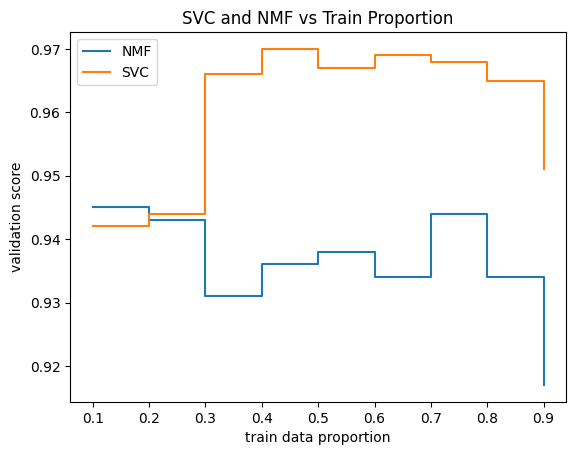

In [609]:
fig, ax = plt.subplots()
ax.set_xlabel("train data proportion")
ax.set_ylabel("validation score")
ax.set_title("SVC and NMF vs Train Proportion")
ax.plot(stats['train proportion'], stats['NMF test accuracy'], label="NMF", drawstyle="steps-post")
ax.plot(stats['train proportion'], stats['SVC test accuracy'], label="SVC", drawstyle="steps-post")
ax.legend()
plt.show() 

In [610]:
# try 0.1 train size for Kaggle submission

tfidf_test = best_vectorizer.transform(df_test.Text)
nmf_test = nmf_models[1].transform(tfidf_test)
yp = np.argmax(nmf_test, axis=1)
cluster_to_index = np.take(permutation, yp)

prediction = np.take(unique_labels, cluster_to_index)

result = pd.DataFrame()
result['ArticleId'] = df_test.ArticleId
result['Category'] = prediction

result.to_csv('./results/sparse_data.csv', index=False)
result

# Kaggle Score: 32.789%

,ArticleId,Category
0,1018,business
1,1319,tech
2,1138,business
3,459,politics
4,1020,business
...,...,...
730,1923,politics
731,373,entertainment
732,1704,sport
733,206,politics


According to the graph, test accuracy decreases for NMF as proportion of the train dataset increases, whereas the opposite is true for SVC. However, with a score of 32.789% for 10% train size, the validity of said relationship is suspect. Thus, we will plot out the accuracies for kaggle submissions.

In [611]:
for p in range(1, 10):
    # Save NMF results
    tfidf_test = best_vectorizer.transform(df_test.Text)
    nmf_test = nmf_models[p].transform(tfidf_test)
    yp = np.argmax(nmf_test, axis=1)
    cluster_to_index = np.take(permutation, yp)
    
    prediction = np.take(unique_labels, cluster_to_index)
    
    result = pd.DataFrame()
    result['ArticleId'] = df_test.ArticleId
    result['Category'] = prediction
    
    result.to_csv(f"./results/variable_train_nmf_{p}.csv", index=False)

    # Save SVC results
    prediction = svc_models[p].predict(tfidf_test)
    
    result = pd.DataFrame()
    result['ArticleId'] = df_test.ArticleId
    result['Category'] = prediction
    
    result.to_csv(f"./results/variable_train_svc_{p}.csv", index=False)
    

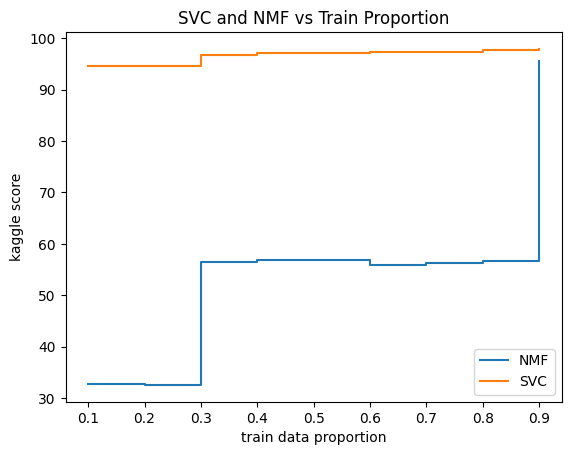

In [612]:
nmf_accuracies_final = [32.789, 32.517, 56.462, 56.870, 56.870, 55.918, 56.326, 56.598, 95.646]
svc_accuracies_final = [94.557, 94.557, 96.734, 97.142, 97.142, 97.278, 97.278, 97.823, 97.959]

fig, ax = plt.subplots()
ax.set_xlabel("train data proportion")
ax.set_ylabel("kaggle score")
ax.set_title("SVC and NMF vs Train Proportion")
ax.plot(stats['train proportion'], nmf_accuracies_final, label="NMF", drawstyle="steps-post")
ax.plot(stats['train proportion'], svc_accuracies_final, label="SVC", drawstyle="steps-post")
ax.legend()
plt.show() 

With this we finally see that SVC is superior to NMF for classification task no matter the proportion of training data used. This makes sense because support vector machine is known to be performant with sparse dataset. One interesting phenomenon we see with NMF scores is that it makes two big jumps between ~32% to ~%55 accuracies and ~55% to ~95% accuracies. Perhaps with sparse dataset, NMF exhibits tendencies to overfit the data. Such explanation would not only resolve the big discrepancies in accuracies among the variable proportions of training data, but it would also explain the fact that validation scores were higher for NMF when using smaller subsets of the training data.

## References

##### [1] https://www.kaggle.com/code/jieshends2020/matrix-factorization-97-acc-with-1-labels/notebook
##### [2] https://www.kaggle.com/code/dazhengzhu/bbc-news-classification
##### [3] https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
##### [4] https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html